📦 Loading data...

🧹 Preprocessing data...

Class Distribution:
fraudulent
0    0.5
1    0.5
Name: proportion, dtype: float64

🔀 Splitting data...

🛠️ Building model...

🚀 Training model...

📊 Evaluating model...

Model Evaluation:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3052
           1       1.00      1.00      1.00      3052

    accuracy                           1.00      6104
   macro avg       1.00      1.00      1.00      6104
weighted avg       1.00      1.00      1.00      6104



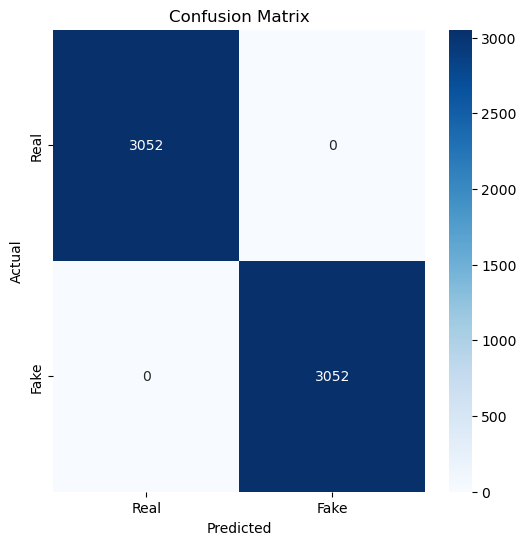


💾 Saving model...
Model saved successfully as 'fake_job_model_v2.pkl'


In [1]:
import pandas as pd
import numpy as np
import joblib
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------- Load Dataset ----------------------
def load_data(file_path='cleaned_fake_real_jobs.csv'):
    """Load and validate the dataset"""
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            raise ValueError("Dataset is empty")
        
        required_columns = ['company_name', 'job_title', 'job_description', 
                          'salary', 'experience', 'qualification', 'skills', 'fraudulent']
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
            
        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

# ---------------------- Preprocess Text ----------------------
def preprocess_text(text):
    """Clean and normalize text data"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Keep meaningful punctuation and symbols
    text = re.sub(r'[^a-zA-Z0-9\s\-$€£%.,!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text if text else "missing"

# ---------------------- Data Preprocessing ----------------------
def preprocess_data(df):
    """Prepare the dataset for modeling"""
    # Text columns processing
    text_cols = ['job_description', 'job_title', 'skills', 'company_name']
    for col in text_cols:
        df[col] = df[col].fillna('missing').apply(preprocess_text)
    
    # Combine text features
    df['job_text'] = (
        df['company_name'] + ' ' +
        df['job_title'] + ' ' +
        df['job_description'] + ' ' +
        df['skills']
    )
    
    # Categorical features
    cat_cols = ['salary', 'experience', 'qualification']
    for col in cat_cols:
        df[col] = df[col].fillna('missing').apply(lambda x: str(x).lower())
    
    # Target variable
    df['fraudulent'] = df['fraudulent'].astype(int)
    
    # Check class balance
    print("\nClass Distribution:")
    print(df['fraudulent'].value_counts(normalize=True))
    
    return df

# ---------------------- Build Model Pipeline ----------------------
def build_model():
    """Construct the machine learning pipeline"""
    
    # Text processing pipeline
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            min_df=2,            # Reduced from 3 to capture more terms
            max_df=0.95,         # Increased from 0.9 to be more inclusive
            stop_words='english',
            sublinear_tf=True
        )),
        ('feature_selection', SelectKBest(chi2, k=2000))
    ])
    
    # Categorical processing pipeline
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Column transformer
    preprocessor = ColumnTransformer(transformers=[
        ('text', text_transformer, 'job_text'),
        ('cat', categorical_transformer, ['salary', 'experience', 'qualification'])
    ])
    
    # Main pipeline with Gradient Boosting
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=42,
            subsample=0.8,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt'
        ))
    ])
    
    return pipeline

# ---------------------- Evaluate Model ----------------------
def evaluate_model(model, X_test, y_test):
    """Generate comprehensive evaluation metrics"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nModel Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return y_proba

# ---------------------- Train and Save ----------------------
def train_and_save_model():
    """Main training function"""
    try:
        print("📦 Loading data...")
        df = load_data()
        
        print("\n🧹 Preprocessing data...")
        df = preprocess_data(df)
        
        features = ['job_text', 'salary', 'experience', 'qualification']
        target = 'fraudulent'
        
        X = df[features]
        y = df[target]
        
        print("\n🔀 Splitting data...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        
        print("\n🛠️ Building model...")
        model = build_model()
        
        print("\n🚀 Training model...")
        model.fit(X_train, y_train)
        
        print("\n📊 Evaluating model...")
        evaluate_model(model, X_test, y_test)
        
        print("\n💾 Saving model...")
        joblib.dump(model, 'fake_3.pkl')
        print("Model saved successfully as 'fake_3.pkl'")
        
        return model
        
    except Exception as e:
        print(f"\n❌ Training failed: {str(e)}")
        raise

if __name__ == '__main__':
    trained_model = train_and_save_model()